In [1]:
import numpy as np
import matplotlib.pyplot as plt
import joblib
import os
import pickle
import sys
import pandas as pd

In [29]:
def reconstruct_density_matrix(expectation):
    """
    Reconstruct a 2×2 density matrix ρ from Bloch-vector expectations.
    
    ρ = ½ (I + ex·σx + ey·σy + ez·σz)
    
    Args:
      expectation: sequence or list [ex, ey, ez]
    Returns:
      2×2 complex ndarray ρ
    """
    ex, ey, ez = expectation
    sigma_x = np.array([[0, 1], [1, 0]], dtype=complex)
    sigma_y = np.array([[0, -1j], [1j, 0]], dtype=complex)
    sigma_z = np.array([[1, 0], [0, -1]], dtype=complex)
    I = np.eye(2, dtype=complex)
    return 0.5 * (I + ex*sigma_x + ey*sigma_y + ez*sigma_z)

def nearest_pure_state(rho):
    """
    Find the pure state closest to ρ by taking the eigenvector 
    of ρ with the largest eigenvalue.
    
    Args:
      rho: 2×2 Hermitian density matrix
    Returns:
      lam_max:    largest eigenvalue (float)
      psi:        corresponding normalized eigenvector (length-2 complex array)
      rho_pure:   pure-state density matrix |ψ⟩⟨ψ|
    """
    eigvals, eigvecs = np.linalg.eigh(rho)
    idx = np.argmax(eigvals)
    lam_max = eigvals[idx]
    psi = eigvecs[:, idx]
    #(Optional) remove global phase so ψ[0] is real:
    # psi *= np.exp(-1j * np.angle(psi[0]))
    rho_pure = np.outer(psi, np.conj(psi))
    return lam_max, psi, rho_pure

def time_series_reconstruction(xs, ys, zs):
    T = len(xs)
    rhos    = np.zeros((T,2,2), dtype=complex)
    eigvals = np.zeros(T)
    psis    = np.zeros((T,2),   dtype=complex)
    rhos_p  = np.zeros((T,2,2), dtype=complex)

    for t, (ex, ey, ez) in enumerate(zip(xs, ys, zs)):
        # 1) reconstruct ρ and find raw eigenvector
        rho       = reconstruct_density_matrix([ex, ey, ez])
        lam, psi_raw, rho_p = nearest_pure_state(rho)

        # # 2) now fix the global phase
        # if t == 0:
        #     # at t=0 just force ψ₀ real & positive
        #     psi_raw *= np.exp(-1j * np.angle(psi_raw[0]))
        #     psi_fixed = psi_raw
        # else:
        #     # for t>0, choose phase so overlap with previous is real+positive
        #     overlap   = np.vdot(psis[t-1], psi_raw)
        #     psi_fixed = psi_raw * np.exp(-1j * np.angle(overlap))

        # 3) store everything
        rhos[t]      = rho
        eigvals[t]   = lam
        psis[t]      = psi_raw
        rhos_p[t]    = rho_p

    return rhos, eigvals, psis, rhos_p

def load_and_reconstruct(initial_state, r,
                         folder="non_hermition_simulation_+x"):
    """
    Load exp_x, exp_y, exp_z for the given initial_state,
    run time_series_reconstruction(), and return:

      {
        "rhos":    rhos,    # mixed-state density matrices ρ(t)
        "eigvals": eigvals, # largest eigenvalue λ_max(t)
        "psis":    psis,    # closest pure-state vectors ψ(t)
        "rhos_p":  rhos_p   # pure-state density matrices |ψ⟩⟨ψ|(t)
      }
    """
    # build the filename you used when pickling
    fname = f"Jdrive={r:.3g}J_ep_state={initial_state}.pkl"
    path = os.path.join(folder, fname)

    # load your saved expectations
    with open(path, "rb") as f:
        data = pickle.load(f)
    xs, ys, zs,rho_ef = data["exp_x"], data["exp_y"], data["exp_z"], data["rho_ef"]

    # run your existing reconstruction routine
    rhos, eigvals, psis, rhos_p = time_series_reconstruction(xs, ys, zs)

    return {
        "rhos":    rhos,
        "eigvals": eigvals,
        "psis":    psis,
        "rhos_p":  rhos_p,
        "rho_ef": rho_ef
    }

def load_and_reconstruct_from_experiment(csv_filename):
    """
    Load a tomography CSV and reconstruct the two-level state trajectory.

    Args:
      csv_filename: path to CSV with columns
                    ["time", "P_f_tomo_z", "P_f_tomo_x", "P_f_tomo_y"]

    Returns:
      dict with keys:
        "time":   1D array of time stamps
        "exp_x":  ⟨σₓ⟩ time series
        "exp_y":  ⟨σᵧ⟩ time series
        "exp_z":  ⟨σ_z⟩ time series
        "rhos":    array (T,2,2) of reconstructed mixed‐state density matrices
        "eigvals": array (T,)   of largest eigenvalues
        "psis":    array (T,2)  of closest pure‐state vectors
        "rhos_p":  array (T,2,2) of pure‐state density matrices
    """
    # 1) load the CSV
    df = pd.read_csv(csv_filename)
    time = df["time"].to_numpy()

    # 2) convert P_f → expectation:
    #    ⟨σ⟩ = P_e - P_f = (1 - P_f) - P_f = 1 - 2 P_f
    exp_z = 1 - 2 * df["P_f_tomo_z"].to_numpy()
    exp_x = 1 - 2 * df["P_f_tomo_x"].to_numpy()
    exp_y = 1 - 2 * df["P_f_tomo_y"].to_numpy()

    # 3) reconstruct the state trajectory
    rhos, eigvals, psis, rhos_p = time_series_reconstruction(exp_x, exp_y, exp_z)

    return {
        "time":    time,
        "exp_x":   exp_x,
        "exp_y":   exp_y,
        "exp_z":   exp_z,
        "rhos":    rhos,
        "eigvals": eigvals,
        "psis":    psis,
        "rhos_p":  rhos_p
    }


In [3]:


def build_phi(psi_e, psi_f):
    """
    Args:
      psi_e: array shape (T,2), pure‐state vectors for initial |e>
      psi_f: array shape (T,2), pure‐state vectors for initial |f>
    Returns:
      phi_ts: array shape (T,2), normalized
              phi(t) = (ψ_e(t) + i ψ_f(t)) / √2  then renormalized
    """
    # form the unnormalized superposition

    
    phi_raw = (psi_e + 1j*psi_f) / np.sqrt(2)

    # compute norms at each t: shape (T,1)
    norms = np.linalg.norm(phi_raw, axis=1, keepdims=True)

    # avoid division by zero just in case
    norms[norms == 0] = 1.0

    # normalize each 2-vector
    phi_ts = phi_raw / norms
    return phi_ts

def build_phi_ref(psi_e, psi_f):
    """
    Args:
      psi_e: array shape (T,2), pure‐state vectors for initial |e>
      psi_f: array shape (T,2), pure‐state vectors for initial |f>
    Returns:
      phi_ts: array shape (T,2), normalized
              phi(t) = (ψ_e(t) + i ψ_f(t)) / √2  then renormalized
    """
    # form the unnormalized superposition

    
    phi_raw = (psi_e - 1j*psi_f) / np.sqrt(2)

    # compute norms at each t: shape (T,1)
    norms = np.linalg.norm(phi_raw, axis=1, keepdims=True)

    # avoid division by zero just in case
    norms[norms == 0] = 1.0

    # normalize each 2-vector
    phi_ts = phi_raw / norms
    return phi_ts

def compute_ofs(phi_ts, psi_x):
    """
    Args:
      phi_ts: array shape (T,2), as returned by build_phi()
      psi_x:  array shape (T,2), pure‐state vectors for initial |x>
    Returns:
      ofs: complex array shape (T,), the overlap at each t
    """

    
    
    # ⟨Φ|ψ⟩ = sum conj(phi) * psi along the second axis
    numer = np.einsum('ij,ij->i', np.conjugate(phi_ts), psi_x)
    # norm = √⟨ψ|ψ⟩  (should be 1 if psi_x was normalized)
    norms = np.linalg.norm(psi_x, axis=1)
    return numer/norms

In [4]:
def enforce_continuous_phase(psi_array: np.ndarray, comp: int = 1) -> np.ndarray:
    """
    Given psi_array of shape (T, 2), returns a new array psi_fixed
    where for each t:
      1) the comp-th component is made real and positive,
      2) the sign is chosen (±) to minimize the jump from psi_fixed[t-1].
    
    Args:
      psi_array: raw eigenvector series, shape (T,2), complex dtype
      comp:      which component to force real (0 or 1)
    
    Returns:
      psi_fixed: shape (T,2), smoothly phased
    """
    T, N = psi_array.shape
    psi_fixed = np.zeros_like(psi_array, dtype=complex)

    # t = 0: cancel phase of component `comp` and force it positive
    phi0 = np.angle(psi_array[0, comp])
    psi0 = psi_array[0] * np.exp(-1j * phi0)
    
    psi_fixed[0] = psi0

    # t = 1…T-1: cancel comp-phase, then pick sign minimizing jump
    for t in range(1, T):
        raw = psi_array[t]
        phi = np.angle(raw[comp])
        cand = raw * np.exp(-1j * phi)    # make comp real
        cand_neg = -cand                  # alternative sign

        prev = psi_fixed[t-1]
        d1 = np.linalg.norm(cand     - prev)
        d2 = np.linalg.norm(cand_neg - prev)

        psi_fixed[t] = cand if d1 < d2 else cand_neg

    return psi_fixed

Text(0.5, 1.0, 'experiment at J=0.231 state=|e> -i|f>')

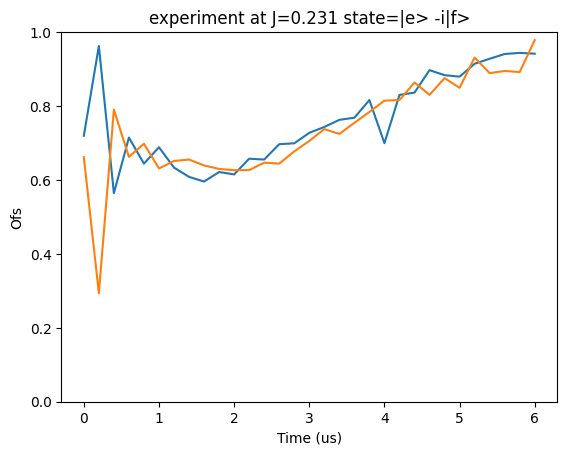

In [ ]:
results_x_exp = load_and_reconstruct_from_experiment("x_full_tomography_J=0_2.csv")
results_e_exp = load_and_reconstruct_from_experiment("e_full_tomography_J=0_2.csv")
results_f_exp = load_and_reconstruct_from_experiment("f_full_tomography_J=0_2.csv")

psi_e_exp = results_e_exp["psis"]   # shape (T,2)
psi_f_exp = results_f_exp["psis"]   # shape (T,2)
psi_x_exp = results_x_exp["psis"]   # shape (T,2)
time= results_x_exp["time"] # shape (T,)

psi_e= enforce_continuous_phase(psi_e_exp,0)
psi_f= enforce_continuous_phase(psi_f_exp,1)
phi_ts_exp = build_phi(psi_e_exp, psi_f_exp)
ofs_ts = compute_ofs(phi_ts_exp, psi_x_exp)
phi_ts_exp_ref = build_phi_ref(psi_e_exp, psi_f_exp)
ofs_ts_ref = compute_ofs(phi_ts_exp_ref, psi_x_exp)
plt.plot(time,abs(ofs_ts))
plt.plot(time,abs(ofs_ts_ref))
plt.ylim(0,1)
plt.xlabel("Time (us)")
plt.ylabel("Ofs")
plt.title("experiment at J=0.231 state=|e> -i|f>")
# plt.legend()
# plt.plot(time,abs(ofs_ts_ref))

(0.0, 1.0)

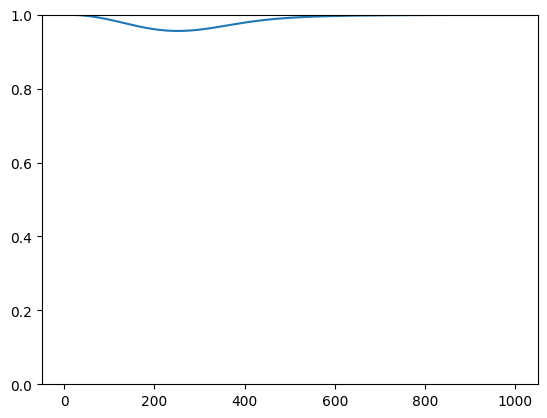

In [49]:
r=1.23
results_x = load_and_reconstruct("x", r)
results_e = load_and_reconstruct("e", r)
results_f = load_and_reconstruct("f", r)

psi_e = results_e["psis"]   # shape (T,2)
psi_f = results_f["psis"]   # shape (T,2)
psi_x = results_x["psis"]   # shape (T,2)


psi_e= enforce_continuous_phase(psi_e,0)
psi_f= enforce_continuous_phase(psi_f,1)
# psi_x_fixed= fix_global_phase(psi_x,0)
# phi_list = []



phi_ts = build_phi(psi_e, psi_f)
ofs_ts = compute_ofs(phi_ts, psi_x)
phi_ts_ref = build_phi_ref(psi_e, psi_f)
ofs_ts_ref = compute_ofs(phi_ts_ref, psi_x)
# plt.plot(abs(ofs_ts))
plt.plot(abs(ofs_ts_ref))
# plt.axvline(200)
plt.ylim(0,1)



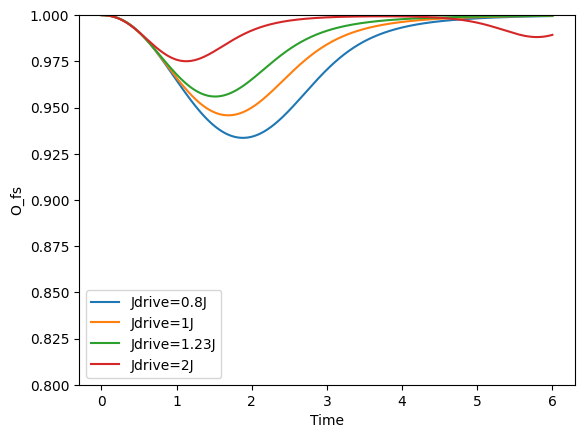

In [43]:
times = np.linspace(0, 6, 1001)

# plt.xlim(0,8)
r_list=[0.8,1,1.23,2]
for i in r_list:
    results_x = load_and_reconstruct("x", i)
    results_e = load_and_reconstruct("e", i)
    results_f = load_and_reconstruct("f", i)

    psi_e = results_e["psis"]   # shape (T,2)
    psi_f = results_f["psis"]   # shape (T,2)
    psi_x = results_x["psis"]   # shape (T,2)

    psi_e= enforce_continuous_phase(psi_e,0)
    psi_f= enforce_continuous_phase(psi_f,1)

    phi_ts = build_phi(psi_e, psi_f)
    ofs_ts = compute_ofs(phi_ts, psi_x)
    phi_ts_ref = build_phi_ref(psi_e, psi_f)
    ofs_ts_ref = compute_ofs(phi_ts_ref, psi_x)
    plt.plot(times,abs(ofs_ts_ref),label=f"Jdrive={i:.3g}J")
    # plt.xlim(0,8)
    plt.ylabel("O_fs")
    plt.xlabel("Time")
    plt.legend()
    plt.ylim(0.8,1)







